# LMT implementation
This notebook presents the framework of the *Logistic Model Tree* algorithm implementation, using auxiliar functions taken from the library *scikitlearn*.  
Where, for building the tree is going to be used `DecisionTreeClassifier` function, which is an optimized version of the CART algorithm, setting the parameters `criterion='entropy'`, `min_samples_split=15`, `min_samples_leaf=5` in order to replicate the tree construction of the original paper and having a similar construction of the C4.5 tree with the parameters just mentioned. In order to control the depth of the tree, it is going to be used parameter `max_depth` at decision of the user.  
For the pruning part, it is going to be used the method that the library already gives, just adding a cross-validation to find the best value of $\alpha$. In this way, we can add a boolean parameter to the tree construcion function indicating if the user needs the tree pruned or not.  
After the construction, the logistic regression models are going to be added in each of the nodes, including the leaves of course, following the *SimpleLogistic* routine, which is the LogitBoost algorithm plus a 5-fold cross-validation in order to obtain the ideal number *M* of boosting iterations. And having the warm-start at each child node.  
Finally, visualizations functions for both the tree and the decision boundaries of the space are going to be implemented.

In [1]:
import os, sys, importlib.util

# 1) Where Jupyter is currently running:
cwd = os.getcwd()
print("Notebook cwd:", cwd)

# 2) Compute the folder above (your project root):
project_root = os.path.abspath(os.path.join(cwd, os.pardir))
print("Project root:", project_root)
print("→ Contains:", os.listdir(project_root))

# 3) Inject it onto sys.path (highest priority):
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("After hack, sys.path[0]:", sys.path[0])

# 4) Confirm Python can now see lmt_pkg:
print("After hack, spec(lmt_pkg):", importlib.util.find_spec("lmt_pkg"))

from lmt_pkg import lmt_final_implementation as lmt
from lmt_pkg import calibration_functions as calibration
from lmt_pkg import logitboost_j_implementation as logitboost


Notebook cwd: c:\Users\allis\Desktop\MITACS\LMT-calibration\Construction and tests
Project root: c:\Users\allis\Desktop\MITACS\LMT-calibration
→ Contains: ['.git', 'Calibration testing', 'Construction and tests', 'Documentation', 'lmt_pkg', 'Papers', 'README.md']
After hack, sys.path[0]: c:\Users\allis\Desktop\MITACS\LMT-calibration
After hack, spec(lmt_pkg): ModuleSpec(name='lmt_pkg', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001A9F6B5BFA0>, origin='c:\\Users\\allis\\Desktop\\MITACS\\LMT-calibration\\lmt_pkg\\__init__.py', submodule_search_locations=['c:\\Users\\allis\\Desktop\\MITACS\\LMT-calibration\\lmt_pkg'])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import cross_val_score

## Building the tree

In [6]:
# Tree pruning function
def prune_tree_cv(X, y, cv=5, scoring='accuracy', random_state=0):
    """
    Prune a DecisionTreeClassifier using minimal cost-complexity pruning
    with cross-validation to select the best ccp_alpha.

    Parameters:
    - X: Training features
    - y: Training labels
    - cv: Number of cross-validation folds
    - scoring: Scoring metric for cross-validation
    - random_state: Random seed for repeatability

    Returns:
    - pruned_tree: DecisionTreeClassifier fitted with the optimal ccp_alpha
    - best_alpha: The ccp_alpha value that achieved the highest CV score
    - alphas: List of tested ccp_alpha values
    - cv_scores: List of mean CV scores corresponding to each alpha
    """
    # Compute pruning path
    base_clf = DecisionTreeClassifier(random_state=random_state)
    path = base_clf.cost_complexity_pruning_path(X, y)
    alphas = path.ccp_alphas[1:]     # drop the 0.0 entry to prune something

    
    # Evaluate each candidate alpha with cross-validation
    cv_scores = []
    for alpha in alphas:
        clf = DecisionTreeClassifier(random_state=random_state, ccp_alpha=alpha, criterion='entropy')
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        cv_scores.append(scores.mean())
    
    # Select the best alpha
    best_alpha = alphas[np.argmax(cv_scores)]
    
    # Train the final pruned tree on the full dataset
    pruned_tree = DecisionTreeClassifier(random_state=random_state, ccp_alpha=best_alpha, min_samples_leaf=5, min_samples_split=15, criterion='entropy')
    pruned_tree.fit(X, y)
    
    return pruned_tree, best_alpha, alphas, cv_scores


# Tree construction function
def construct_tree(X, y, size='regular', pruning=False, cv=5, scoring='accuracy', random_state=0):
    """
    Constructs a decision tree classifier with specified parameters.
    Parameters:
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    size : 'shallow', 'regular', or 'overfit'
    pruning : bool, apply cost-complexity pruning if True
    cv, scoring, random_state: passed to prune_tree_cv

    Returns:
    clf : DecisionTreeClassifier. A fitted decision tree classifier.
    """
    # define hyperparameter presets
    presets = {
        'shallow':  {'max_depth': 2,  'min_samples_leaf': 20, 'min_samples_split': 40},
        'regular':  {'min_samples_leaf': 5,  'min_samples_split': 15}, # Paper's implementation
        'overfit':  {'max_depth': None,'min_samples_leaf': 1,  'min_samples_split': 2},
    }

    params = presets.get(size)
    if params is None:
        raise ValueError("Invalid size parameter. Choose from 'shallow', 'regular', or 'overfit'.")
    
    # Create a decision tree classifier with specified parameters
    clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=random_state, **params)
    clf.fit(X, y)

    # Pruning with CART-like method
    if pruning:
        pruned_tree, best_alpha, alphas, cv_scores = prune_tree_cv(X, y, cv=cv, scoring=scoring, random_state=random_state)
        clf = pruned_tree
        print("Best alpha:", best_alpha)
        print("Alphas tested:", alphas)
        print("Cross-validation scores:", cv_scores)    

        # Plot alphas vs. cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.plot(alphas, cv_scores, marker='o')
        plt.title("Cross-Validation Scores vs. Alpha Values")
        plt.xlabel("Alpha (ccp_alpha)")
        plt.ylabel("Cross-Validation Score")
        plt.show()


    return clf

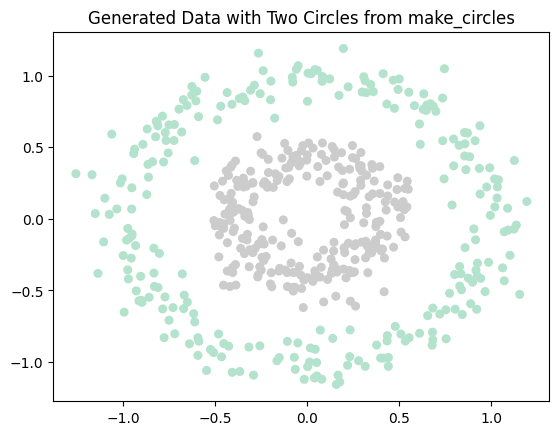

Best alpha: 0.125
Alphas tested: [0.125]
Cross-validation scores: [0.9925]


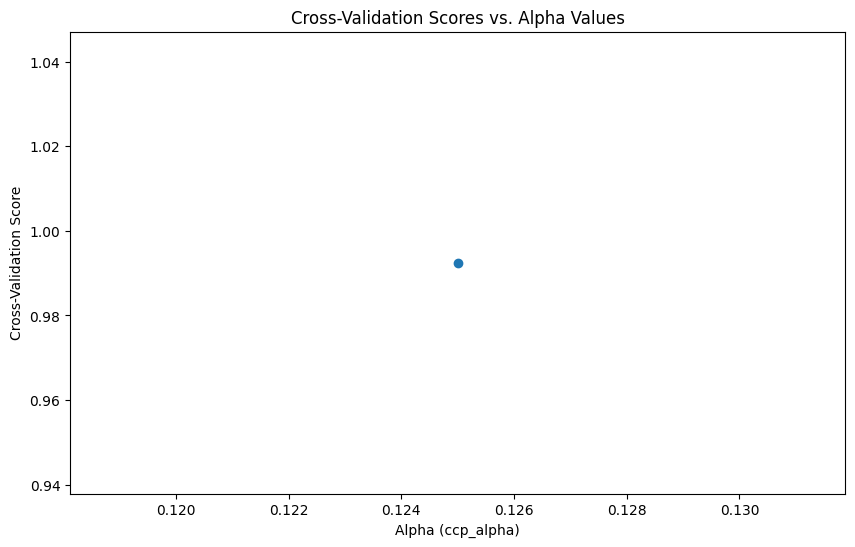

Pruned Tree - Accuracy: 0.9900, AUC: 0.9900, Log Loss: 0.3604


In [7]:
# Testing
from sklearn.datasets import load_breast_cancer
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data   
y = data.target

# Generate synthetic data using make_circles
X, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Pastel2)    
plt.title("Generated Data with Two Circles from make_circles")
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Construct the decision tree with pruning
clf_pruned = construct_tree(X_train, y_train, pruning=True)

# Evaluate the pruned tree
y_pred_pruned = clf_pruned.predict(X_test)

# Calculate accuracy, AUC, and log loss for the pruned tree
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
auc_pruned = roc_auc_score(y_test, clf_pruned.predict_proba(X_test)[:, 1])
log_loss_pruned = log_loss(y_test, clf_pruned.predict_proba(X_test))

# Print the results
print(f"Pruned Tree - Accuracy: {accuracy_pruned:.4f}, AUC: {auc_pruned:.4f}, Log Loss: {log_loss_pruned:.4f}")

In [8]:
# Example usage:
clf_shallow = construct_tree(X_train, y_train, size='shallow', pruning=False)
clf_regular = construct_tree(X_train, y_train, size='regular', pruning=False)
clf_overfit = construct_tree(X_train, y_train, size='overfit', pruning=False)
# Evaluate the shallow tree
y_pred_shallow = clf_shallow.predict(X_test)
# Calculate accuracy, AUC, and log loss for the shallow tree
accuracy_shallow = accuracy_score(y_test, y_pred_shallow)   
auc_shallow = roc_auc_score(y_test, clf_shallow.predict_proba(X_test)[:, 1])
log_loss_shallow = log_loss(y_test, clf_shallow.predict_proba(X_test))  
# Print the results for the shallow tree
print(f"Shallow Tree - Accuracy: {accuracy_shallow:.4f}, AUC: {auc_shallow:.4f}, Log Loss: {log_loss_shallow:.4f}")

# Evaluate the regular tree
y_pred_regular = clf_regular.predict(X_test)
# Calculate accuracy, AUC, and log loss for the regular tree
accuracy_regular = accuracy_score(y_test, y_pred_regular)
auc_regular = roc_auc_score(y_test, clf_regular.predict_proba(X_test)[:, 1])
log_loss_regular = log_loss(y_test, clf_regular.predict_proba(X_test))
# Print the results for the regular tree
print(f"Regular Tree - Accuracy: {accuracy_regular:.4f}, AUC: {auc_regular:.4f}, Log Loss: {log_loss_regular:.4f}")

# Evaluate the overfit tree
y_pred_overfit = clf_overfit.predict(X_test)
# Calculate accuracy, AUC, and log loss for the overfit tree
accuracy_overfit = accuracy_score(y_test, y_pred_overfit)
auc_overfit = roc_auc_score(y_test, clf_overfit.predict_proba(X_test)[:, 1])
log_loss_overfit = log_loss(y_test, clf_overfit.predict_proba(X_test))
# Print the results for the overfit tree
print(f"Overfit Tree - Accuracy: {accuracy_overfit:.4f}, AUC: {auc_overfit:.4f}, Log Loss: {log_loss_overfit:.4f}")

Shallow Tree - Accuracy: 0.8200, AUC: 0.8200, Log Loss: 0.7370
Regular Tree - Accuracy: 0.9900, AUC: 0.9900, Log Loss: 0.3604
Overfit Tree - Accuracy: 0.9900, AUC: 0.9900, Log Loss: 0.3604


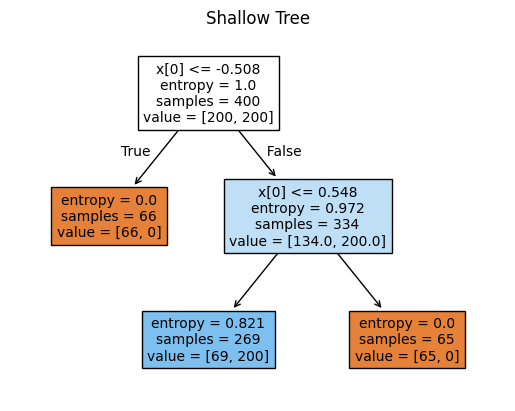

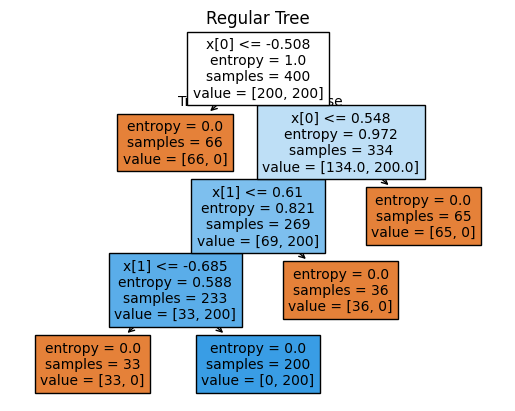

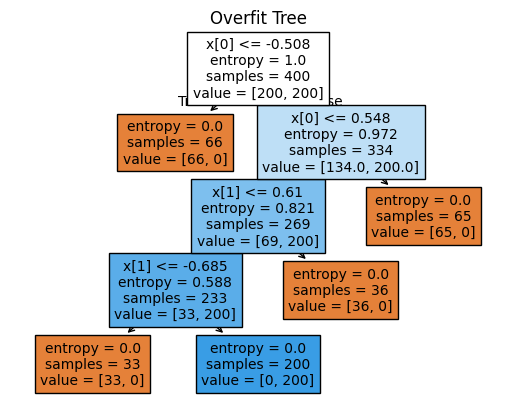

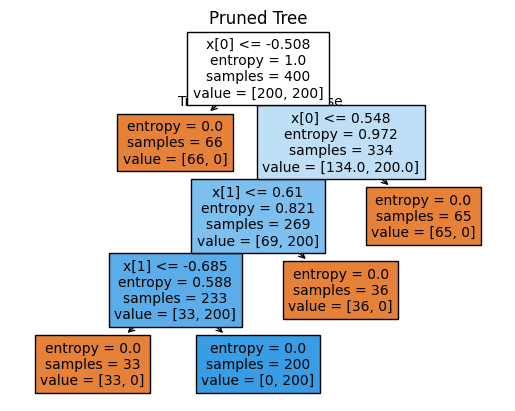

In [9]:
tree.plot_tree(clf_shallow, filled=True, fontsize=10)
plt.title("Shallow Tree")
plt.show()

tree.plot_tree(clf_regular, filled=True, fontsize=10)
plt.title("Regular Tree")
plt.show()

tree.plot_tree(clf_overfit, filled=True, fontsize=10)
plt.title("Overfit Tree")
plt.show()

tree.plot_tree(clf_pruned, filled=True, fontsize=10)
plt.title("Pruned Tree")
plt.show()

## SimpleLogistic

In [10]:
import logitboost_j_implementation as logitboost
# Example usage of SimpleLogistic routine
learners_sl, J, M_star, cv_errs = logitboost.simple_logistic_fit(
    X_train,
    y_train,
    n_estimators=200,    # max rounds to consider
    eps=1e-5,
    cv_splits=5,
    warm_start=None,     # or pass (init_learners, J) to continue
    random_state=42
)

In [11]:
print(f"Selected boosting rounds M* = {M_star}")

# --- 3) Evaluate on the test set ---
from logitboost_j_implementation import logitboost_predict

# preds: shape (n_samples,)
preds = logitboost_predict(X_test, learners_sl, J)

accuracy = np.mean(preds == y_test)
print(f"Test accuracy of SimpleLogistic model: {accuracy:.3f}")

Selected boosting rounds M* = 2
Test accuracy of SimpleLogistic model: 0.450


In [12]:
# suppose you fit 50 rounds first:
init_learners, J0 = logitboost.logitboost_fit(X_train, y_train,
                                   n_estimators=50, eps=1e-5)

# then run SimpleLogistic from there (will only train more as needed)
learners_sl_ws, J, M_star_ws, cv_errs_ws = logitboost.simple_logistic_fit(
    X_train, y_train,
    n_estimators=200,
    eps=1e-5,
    cv_splits=5,
    warm_start=(init_learners, J0),
    random_state=42
)
print(f"Warm-started, final M* = {M_star_ws} (started from 50)")


Warm-started, final M* = 2 (started from 50)


In [13]:
# test accuracy
preds = logitboost_predict(X_test, learners_sl_ws, J)

accuracy = np.mean(preds == y_test)
print(f"Test accuracy of SimpleLogistic model: {accuracy:.3f}")

Test accuracy of SimpleLogistic model: 0.450


## Merge with *SimpleLogistic* at every node

In [14]:
def fit_logistic_model_tree(
    X, y,
    size='regular',
    pruning=True,
    tree_random_state=0,
    lb_n_estimators=200,
    lb_eps=1e-5,
    lb_cv_splits=5,
    lb_random_state=0
):
    """
    Build a DecisionTree, then at each node fit a SimpleLogistic (LogitBoost) model
    using the samples that reach that node. Root has no warm_start, children
    inherit their parent's model as warm_start.

    Returns
    -------
    clf_tree     : fitted DecisionTreeClassifier
    node_models  : dict mapping node_id -> {
                      'learners': [...],
                      'J': int,
                      'M_star': int,
                      'cv_errors': array
                   }
    """
    # 1) Fit the base tree
    clf_tree = construct_tree(
        X, y,
        size=size,
        pruning=pruning
    )
    tree = clf_tree.tree_
    n_nodes = tree.node_count

    # 2) Pre-compute the decision_path matrix
    # decision_path gives you a sparse indicator matrix (n_samples x n_nodes)
    node_indicator = clf_tree.decision_path(X)

    # 3) Recursive traversal to fit logitboost at each node
    node_models = {}

    def recurse(node_id, warm_start):
        # mask of samples that pass through this node
        sample_mask = node_indicator[:, node_id].toarray().ravel().astype(bool)
        X_node = X[sample_mask]
        y_node = y[sample_mask]

        # Fit SimpleLogistic on this node's data
        learners, J, M_star, cv_errs = logitboost.simple_logistic_fit(
            X_node, y_node,
            n_estimators=lb_n_estimators,
            eps=lb_eps,
            cv_splits=lb_cv_splits,
            warm_start=warm_start,
            random_state=lb_random_state
        )

        # store the fitted LogitBoost model for this node
        node_models[node_id] = {
            'learners': learners,
            'J': J,
            'M_star': M_star,
            'cv_errors': cv_errs
        }

        # propagate to children if not a leaf
        left = tree.children_left[node_id]
        right = tree.children_right[node_id]
        if left != -1:
            recurse(left, warm_start=(learners, J))
        if right != -1:
            recurse(right, warm_start=(learners, J))

    # start at root (node 0) with no warm start
    recurse(0, warm_start=None)

    return clf_tree, node_models


In [15]:
# --- 2) Fit a plain tree and our hybrid tree+LogitBoost models ---
# a) Plain tree
clf_tree = construct_tree(X_train, y_train, size='regular', pruning=False)

Best alpha: 0.125
Alphas tested: [0.125]
Cross-validation scores: [0.9925]


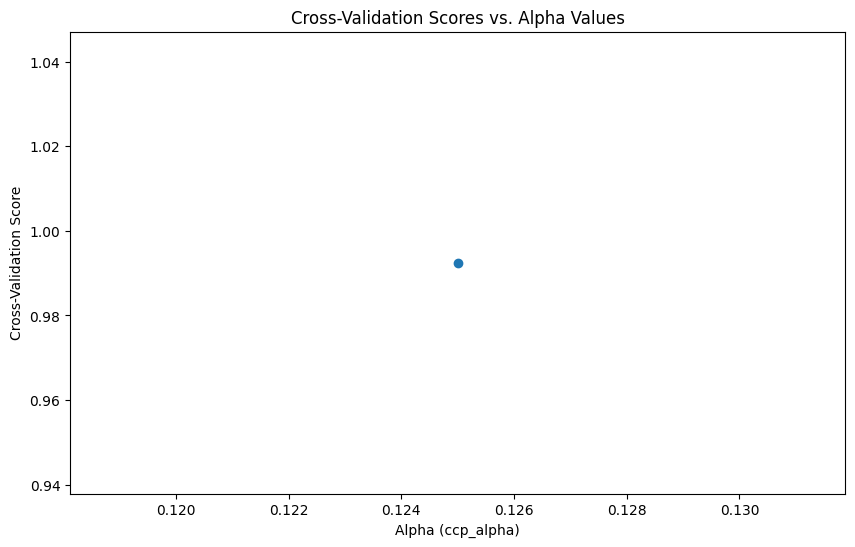

In [16]:
# b) Logistic Model Tree
clf_tree2, node_models = fit_logistic_model_tree(
    X_train, y_train,
    size='regular',
    pruning=True,
    tree_random_state=42,
    lb_n_estimators=200,
    lb_eps=1e-5,
    lb_cv_splits=5,
    lb_random_state=42
)

In [17]:
# --- 3) Predict & compare ---

# 3a) plain tree
y_pred_tree = clf_tree.predict(X_test)

# 3b) LMT: use the LogitBoost model at each leaf
def predict_lmt(X):
    leaf_ids = clf_tree2.apply(X)
    preds = []
    for xi, leaf in zip(X, leaf_ids):
        # grab the model fitted on that node
        mdl = node_models[leaf]
        learners, J = mdl['learners'], mdl['J']
        # predict label
        p = logitboost_predict(xi.reshape(1, -1), learners, J)
        preds.append(p[0])
    return np.array(preds)

y_pred_lmt = predict_lmt(X_test)

# --- 4) Evaluation ---
print("Plain tree accuracy:           ", np.mean(y_pred_tree == y_test))
print("Logistic Model Tree accuracy:  ", np.mean(y_pred_lmt == y_test))

Plain tree accuracy:            0.99
Logistic Model Tree accuracy:   0.51


## Merge with *SimpleLogistic* only at the root node

In [73]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy import sparse

# Assume these are imported:
# from logitboost_j_implementation import construct_tree, simple_logistic_fit, logitboost_fit

def fit_logistic_model_tree_v2(
    X, y,
    size='regular',
    pruning=True,
    tree_random_state=0,
    lb_n_estimators=200,
    lb_eps=1e-5,
    lb_cv_splits=5,
    lb_random_state=0
):
    """
    V5: SimpleLogistic only at root (no warm-start), then
    classical LogitBoost at every other node for M* rounds,
    passing warm_start=parent_model so children inherit.

    Returns
    -------
    clf_tree     : fitted DecisionTreeClassifier
    node_models  : dict[node_id] = {
                      'learners': list,
                      'J': int,
                      'M_star': int,
                      'cv_errors': array or None
                   }
    """
    # 1) Fit the base decision tree
    clf_tree = construct_tree(
        X, y,
        size=size,
        pruning=pruning,
        random_state=tree_random_state
    )
    tree_ = clf_tree.tree_
    n_nodes = tree_.node_count

    # 2) Root: run SimpleLogistic to get M_star
    root_learners, J, M_star, cv_errs = logitboost.simple_logistic_fit(
        X, y,
        n_estimators=lb_n_estimators,
        eps=lb_eps,
        cv_splits=lb_cv_splits,
        warm_start=None,
        random_state=lb_random_state
    )

    # 3) Precompute sample-to-node mapping
    node_indicator = clf_tree.decision_path(X)

    node_models = {}

    def recurse(node_id, warm_start):
        # mask of samples reaching this node
        mask = node_indicator[:, node_id].toarray().ravel().astype(bool) \
               if sparse.issparse(node_indicator) \
               else node_indicator[:, node_id].astype(bool)

        X_node, y_node = X[mask], y[mask]

        if node_id == 0:
            # root: store SimpleLogistic result
            learners_node, J_node, cv_err_node = root_learners, J, cv_errs
        else:
            # child: classical LogitBoost for M_star rounds, warm-start from parent
            learners_node, J_node = logitboost.logitboost_fit(
                X_node, y_node,
                n_estimators=M_star,
                eps=lb_eps,
                warm_start=warm_start
            )
            cv_err_node = None

        node_models[node_id] = {
            'learners': learners_node,
            'J': J_node,
            'M_star': M_star,
            'cv_errors': cv_err_node
        }

        # recurse to children, passing this node's model as warm_start
        left, right = tree_.children_left[node_id], tree_.children_right[node_id]
        if left != -1:
            recurse(left, warm_start=(learners_node, J_node))
        if right != -1:
            recurse(right, warm_start=(learners_node, J_node))

    # start at root
    recurse(0, warm_start=None)

    return clf_tree, node_models


Best alpha: 0.014385614385614387
Alphas tested: [0.00218083 0.0029304  0.00431133 0.00559513 0.00743872 0.0086638
 0.01291987 0.01438561 0.02404453 0.02442056 0.0306549  0.3228506 ]
Cross-validation scores: [0.9340659340659341, 0.9340659340659341, 0.9340659340659341, 0.9362637362637363, 0.9362637362637363, 0.9362637362637363, 0.9384615384615385, 0.9406593406593406, 0.9318681318681319, 0.9318681318681319, 0.9362637362637363, 0.887912087912088]


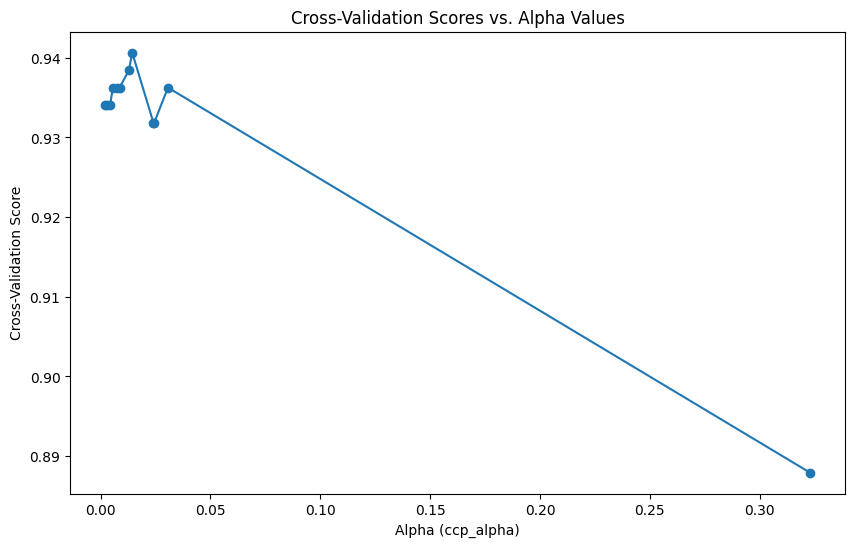

In [74]:
# b) Logistic Model Tree
clf_tree2, node_models = fit_logistic_model_tree_v2(
    X_train, y_train,
    size='regular',
    pruning=True,
    tree_random_state=42,
    lb_n_estimators=200,
    lb_eps=1e-5,
    lb_cv_splits=5,
    lb_random_state=42
)

In [75]:
# --- 3) Predict & compare ---

# 3a) plain tree
y_pred_tree = clf_tree.predict(X_test)

# 3b) LMT: use the LogitBoost model at each leaf
def predict_lmt(X):
    leaf_ids = clf_tree2.apply(X)
    preds = []
    for xi, leaf in zip(X, leaf_ids):
        # grab the model fitted on that node
        mdl = node_models[leaf]
        learners, J = mdl['learners'], mdl['J']
        # predict label
        p = logitboost_predict(xi.reshape(1, -1), learners, J)
        preds.append(p[0])
    return np.array(preds)

y_pred_lmt = predict_lmt(X_test)

# --- 4) Evaluation ---
print("Plain tree accuracy:           ", np.mean(y_pred_tree == y_test))
print("Logistic Model Tree accuracy:  ", np.mean(y_pred_lmt == y_test))

Plain tree accuracy:            0.9649122807017544
Logistic Model Tree accuracy:   0.9122807017543859


## Visualizations

In [76]:
def extract_linear_models(learners, J, n_features):
    intercepts = np.zeros(J)
    coefs      = np.zeros((J, n_features))
    for round_learners in learners:
        b0s = np.array([b0 for (_, b0, _) in round_learners])
        b1s = np.array([b1 for (_, _, b1) in round_learners])
        mean_b0, mean_b1 = b0s.mean(), b1s.mean()
        for j, (idx, b0, b1) in enumerate(round_learners):
            adj_b0 = (J - 1)/J*(b0 - mean_b0)
            adj_b1 = (J - 1)/J*(b1 - mean_b1)
            intercepts[j] += adj_b0
            coefs[j, idx]  += adj_b1
    return intercepts, coefs

In [77]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from scipy import sparse

# assumes extract_linear_models is available in the namespace

def plot_tree_with_linear_models(
    clf_tree,
    node_models,
    X,
    class_names=None,
    show_internal=False,
    model_threshold=1e-6
):
    """
    Draws a DecisionTree with plot_tree and then appends J linear models
    F_j(x) = intercepts[j] + sum_k coefs[j,k] * x[k] in each leaf and, optionally,
    in internal nodes as well.

    Parameters
    ----------
    clf_tree : DecisionTreeClassifier
    node_models : dict[node_id] -> {'learners': [...], 'J': int, ...}
    X : array-like, shape (n_samples, n_features)
    class_names : list of str, optional
        Names of classes; if None, uses '0', '1', ...
    show_internal : bool, default False
        If True, show linear models in all nodes; otherwise only in leaves.
    model_threshold: float
        Gives the threshold of printing the coefficients of the model, if coef>model_threshold it is going to be printed.
    """
    n_features = X.shape[1]
    feature_labels = [f"x[{k}]" for k in range(n_features)]

    # precompute intercepts & coefs for each node
    intercepts_dict = {}
    coefs_dict      = {}
    for nid, mdl in node_models.items():
        ints, cos = extract_linear_models(mdl['learners'], mdl['J'], n_features)
        intercepts_dict[nid] = ints
        coefs_dict[nid]      = cos

    # draw base tree with node IDs
    fig, ax = plt.subplots(figsize=(16, 8))
    plot_tree(
        clf_tree,
        feature_names=feature_labels,
        class_names=class_names,
        filled=True,
        node_ids=True,
        ax=ax,
        fontsize=8
    )

    # identify leaf node IDs
    tree_    = clf_tree.tree_
    leaf_ids = [i for i in range(tree_.node_count)
                if tree_.children_left[i] == -1]

    # append formulas in each text box per node
    for txt in ax.texts:
        full = txt.get_text()
        first_line = full.split("\n", 1)[0]
        m = re.search(r'\b(\d+)\b', first_line)
        if not m:
            continue
        node_id = int(m.group(1))
        # skip internals if not requested
        if not show_internal and node_id not in leaf_ids:
            continue

        ints = intercepts_dict[node_id]
        cos  = coefs_dict[node_id]
        J    = len(ints)
        lines = []
        for j in range(J):
            b = ints[j]
            parts = [f"F{j}(x)={b:.2f}"]
            for k in range(n_features):
                a = cos[j, k]
                if abs(a) > model_threshold:
                    parts.append(f"{'+' if a>=0 else '-'}{abs(a):.2f}*x[{k}]")
            lines.append(" ".join(parts))

        txt.set_text(full + "\n" + "\n".join(lines))

    plt.tight_layout()
    plt.show()



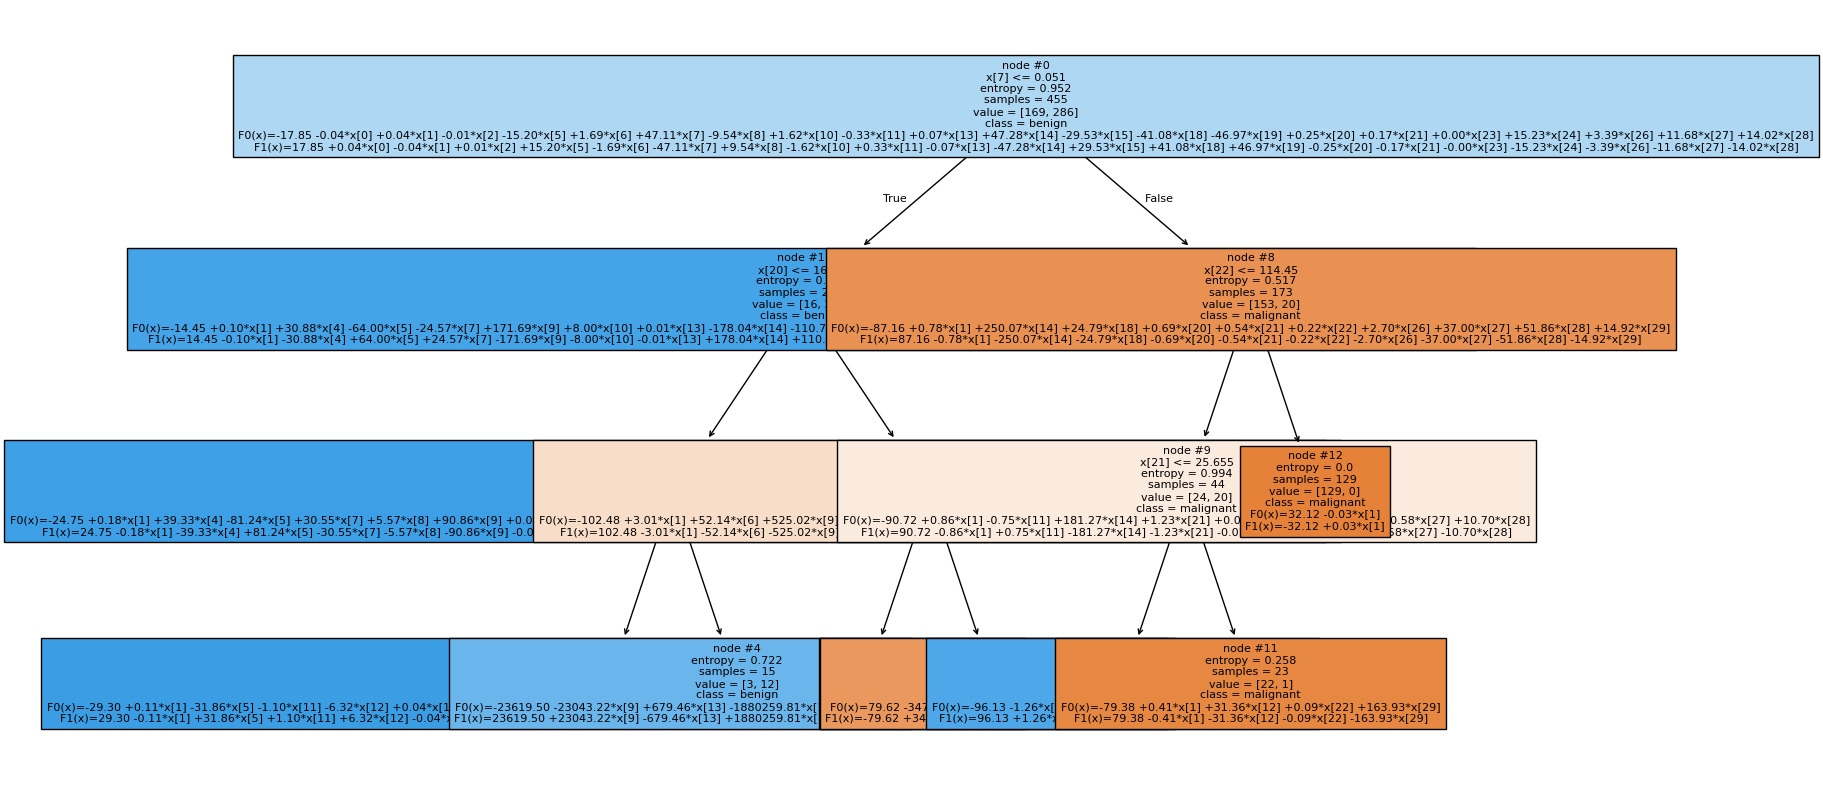

In [78]:
plot_tree_with_linear_models(
    clf_tree2,
    node_models,
    X=X_train,
    class_names=data.target_names,
    show_internal=True
)


In [79]:
# Visualize the coefficients of just one node
ints, coefs = extract_linear_models(node_models[2]['learners'], J, X.shape[1])
print("Node #2 coefs:", coefs)

Node #2 coefs: [[ 0.00000000e+00  1.77342700e-01  0.00000000e+00  0.00000000e+00
   3.93329051e+01 -8.12351526e+01  0.00000000e+00  3.05518760e+01
   5.56819121e+00  9.08614068e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  7.92809938e-02  7.95522076e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.17656458e+01 -2.48171720e+02
   0.00000000e+00  1.06077412e-01  0.00000000e+00  2.67116880e-03
   1.60110666e+01  4.37481417e+00  2.37024112e+00  4.61130754e+01
   2.72991968e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.77342700e-01  0.00000000e+00  0.00000000e+00
  -3.93329051e+01  8.12351526e+01  0.00000000e+00 -3.05518760e+01
  -5.56819121e+00 -9.08614068e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.92809938e-02 -7.95522076e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.17656458e+01  2.48171720e+02
   0.00000000e+00 -1.06077412e-01  0.00000000e+00 -2.67116880e-03
  -1.60110666e+01 -4.37481417e+00 -2.37024112e+00 -4.61130754e+01
  -2.72991968e+00  0.00000

In [80]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_tree_decision_surface(
    X, y,
    feature_pair,
    size='regular',
    pruning=False,
    feature_names=None,
    class_names=None,
    plot_colors="br",
    plot_step=0.02,
    cmap=plt.cm.RdYlBu,
    ax=None
):
    i, j = feature_pair
    X2 = X[:, [i, j]]

    # Fit the tree
    clf = construct_tree(X2, y, size=size, pruning=pruning)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    # Decision surface
    DecisionBoundaryDisplay.from_estimator(
        clf, X2,
        response_method="predict",
        cmap=cmap,
        plot_method="contourf",
        grid_resolution=int(1/plot_step),
        ax=ax
    )

    # Scatter points
    classes = np.unique(y)
    has_cls = class_names is not None
    for cls, color in zip(classes, plot_colors):
        mask = (y == cls)
        lbl  = class_names[cls] if has_cls else str(cls)
        ax.scatter(
            X2[mask, 0], X2[mask, 1],
            c=color, edgecolor="k", s=20,
            label=lbl
        )

    # Axis labels
    if feature_names is not None:
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[j])
    else:
        ax.set_xlabel(f"x[{i}]")
        ax.set_ylabel(f"x[{j}]")

    ax.legend(loc="lower right", fontsize="small")
    ax.set_title(f"Decision surface using features {i} & {j}")
    return ax


<Axes: title={'center': 'Decision surface using features 7 & 20'}, xlabel='mean concave points', ylabel='worst radius'>

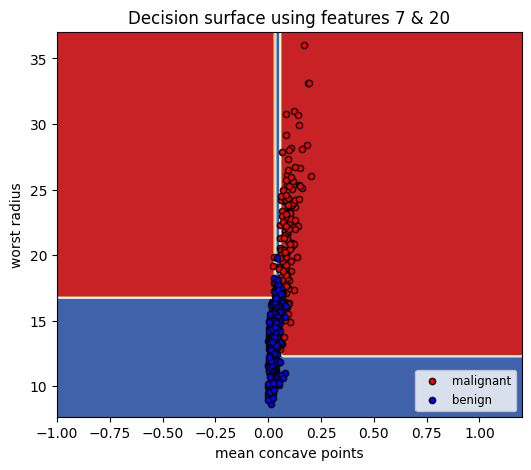

In [81]:
plot_tree_decision_surface(
    X_train, y_train,
    feature_pair=(7, 20),
    size='regular',
    pruning=False,
    feature_names=data.feature_names,
    class_names=data.target_names,
    plot_colors="rb",
    plot_step=0.01
)